<a href="https://colab.research.google.com/github/MachineAbiogenesis/Algorithms/blob/master/Text_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
import io
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# Dataset is now stored in a Pandas Dataframe

Saving train.csv to train (4).csv


In [2]:
uploaded2 = files.upload()
df_test = pd.read_csv(io.BytesIO(uploaded2['test.csv']))
# Dataset is now stored in a Pandas Dataframe

Saving test.csv to test (4).csv


In [3]:
df_train.head();
df_test.head();

In [4]:
X_train,Y_train = df_train['text'],df_train['emotion']
X_test,Y_test = df_test['text'],df_test['emotion']

In [5]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
import nltk
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
with tf.device('/device:GPU:0'):
  lem=WordNetLemmatizer()
  sw_nltk =stopwords.words('english')

  for i,sent in enumerate(X_train):
  #print(i)
  #sent=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sent)
  
    sent=sent.lower()
    sent=re.sub('https:\/\/\S+','',sent)
    sent=re.sub('@\S+','',sent)
    sent=re.sub('&[a-zA-Z]+;','',sent)
    sent=re.sub('#\S+','',sent)
    sent=re.sub('[^a-zA-Z0-9]',' ',sent)
    sent=sent.split()
    wds=''
    
    for word in sent:
      if word not in sw_nltk:
        word=lem.lemmatize(word)
        wds+=' '
        wds+=word
    X_train[i]=wds

<ipython-input-6-dd63ee9b2d4a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]=wds


In [7]:
len(X_train)


254539

In [8]:

from sklearn.model_selection import train_test_split
#90% to train , 10% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train,Y_train, test_size=0.1, random_state=42)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer(
    num_words=254539,      
    oov_token="<OOV>"
)


tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(X_train)

padded_seq_train = pad_sequences(sequences_train, maxlen=75,padding='pre',dtype='float32')

sequences_test = tokenizer.texts_to_sequences(X_val)

padded_seq_test = pad_sequences(sequences_test, maxlen=75,padding='pre',dtype='float32')



In [10]:

sequences_eval = tokenizer.texts_to_sequences(X_test)

padded_seq_eval = pad_sequences(sequences_eval, maxlen=75,padding='pre',dtype='float32')

In [34]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
 
 
early_stopping = EarlyStopping(patience=3, monitor='val_loss')
	

reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.001,
	                        patience=5, mode='min',
	                        verbose=1)
	

model_checkpoint = ModelCheckpoint(monitor='val_loss', 
	                             filepath='./best_model.h5', 
	                             save_best_only=True)
	

callbacks = [
	    early_stopping,
	    reduce_lr,
	    model_checkpoint
	]
	


In [39]:
vocab_size = 229085
embedding_dim = 2
max_length = 75

import tensorflow.keras as tk
import tensorflow as tf
import numpy as np

my_model1 = tk.Sequential([
   tk.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
   tk.layers.Bidirectional(tk.layers.LSTM(32,return_sequences=True,kernel_initializer='he_normal')),
   tk.layers.Bidirectional(tk.layers.LSTM(32)),
   tk.layers.Dense(64, activation='relu'),
   tk.layers.Dropout(0.2),
   tk.layers.Dense(1, activation='sigmoid')
])

padded_seq_train=np.array(padded_seq_train)
y_train=np.array(y_train)
padded_seq_test=np.array(padded_seq_test)
y_val=np.array(y_val)


my_model1.compile(optimizer='adam',
                loss = tf.keras.losses.binary_crossentropy,
                metrics=['accuracy'])

history1=my_model1.fit(padded_seq_train,
            y_train,
            steps_per_epoch=1000,
    
            epochs=15,
            validation_data=(padded_seq_test, y_val),callbacks=[callbacks])

Epoch 1/15
1000/1000 [==============================] - 65s 57ms/step - loss: 0.1693 - accuracy: 0.9260 - val_loss: 0.0957 - val_accuracy: 0.9621 - lr: 0.0010
Epoch 2/15
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0577 - accuracy: 0.9772 - val_loss: 0.0809 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 3/15
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0388 - accuracy: 0.9854 - val_loss: 0.0911 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 4/15
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0297 - accuracy: 0.9893 - val_loss: 0.0965 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 5/15
1000/1000 [==============================] - 28s 28ms/step - loss: 0.0240 - accuracy: 0.9915 - val_loss: 0.1084 - val_accuracy: 0.9677 - lr: 0.0010


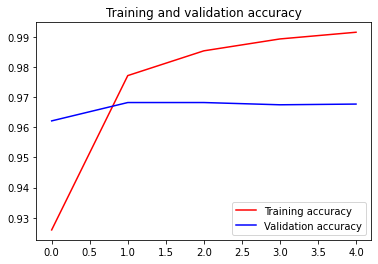

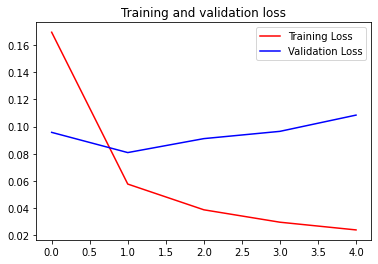

In [40]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy'] ### YOUR CODE HERE
val_acc = history1.history['val_accuracy'] ### YOUR CODE HERE
loss = history1.history['loss'] ### YOUR CODE HERE
val_loss = history1.history['val_loss'] ### YOUR CODE HERE

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
padded_seq_eval=np.array(padded_seq_eval)
Y_test=np.array(Y_test)

In [42]:
my_model1.evaluate(padded_seq_eval,Y_test,steps=50)

50/50 [==============================] - 1s 10ms/step - loss: 0.1212 - accuracy: 0.9645


[0.12124066799879074, 0.9644662737846375]